In [11]:
import numpy as np

Import the dataset downloaded from source:

In [12]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [13]:
#List of train data files:
data_batches = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5',]
#Unpickling every batch in the list:
train_data_dicts = [unpickle(batch) for batch in data_batches]
#Unpickling test data file:
test_data_dict = unpickle('test_batch')
#Unpickling label names file:
label_names_dicts = unpickle('batches.meta')
label_names = [str(label, 'utf-8') for label in label_names_dicts[b'label_names']]

In [14]:
#Group batches and define train data:
x_train = np.empty(shape=(0,3072),dtype=np.uint8)
y_train = []
for dict in train_data_dicts:
    x_train = np.append(x_train, dict[b'data'], axis = 0)
    y_train += dict[b'labels']
y_train = np.asarray(y_train)

#Define test data:
x_test = np.array(test_data_dict[b'data'])
y_test = np.array(test_data_dict[b'labels'])

#Convert x to image format:
x_train = x_train.reshape(50000,3,32,32).transpose(0,2,3,1)
x_test = x_test.reshape(10000,3,32,32).transpose(0,2,3,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


In [15]:
#function to plot 6 random images:
def plot_6(x=x_test,y=y_test,y_hat=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(2,3)
    i_list = np.random.randint(low=0, high=10000, size = 6) #generate list of random indices
    i=0
    for row in ax:
        for col in row:
            col.axis('off')
            #get image:
            img = x[i_list[i]][:16,:,:]
            col.imshow(img)
            #get label:
            label_no = y[i_list[i]]
            label = label_names[label_no]
    
            if y_hat: #print predictions if they have been made
                predicted_label_no = y_hat[i_list[i]]
                predicted_label = label_names[predicted_label_no]
                col.set_title(f'Index: {i_list[i]}\nLabel: {label}\nPredicted: {predicted_label}',
                              loc='left', fontdict={'fontsize': 8})
                fig.suptitle('Example Predictions')
            else: 
                col.set_title(f'Index: {i_list[i]}\nLabel: {label}',
                              loc='left', fontdict={'fontsize': 8})
                fig.suptitle('Example Images')
            
            #update to the next generated index
            i+=1
    plt.show()

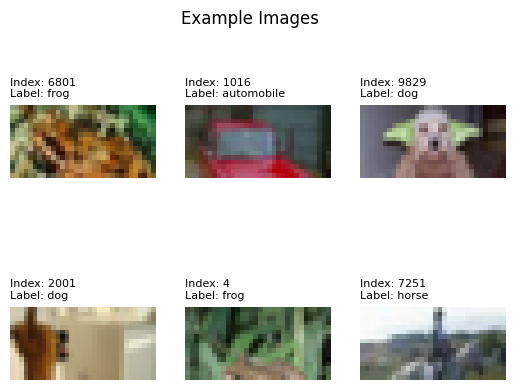

In [16]:
plot_6()

# <center>CNN Structure<center>

In [76]:

class ConvolutionalLayer:
    def __init__(self, no_of_filters=1, filter_size=3, stride=1, pad=0, input_shape=None):
        self.no_of_filters = no_of_filters
        self.filter_size = filter_size
        self.stride = stride
        self.pad = pad
        self.filters = np.random.randn(no_of_filters, filter_size, filter_size, input_shape[-1]) * np.sqrt(2/np.prod(input_shape)) # initialise the set of filters with he initialization method
        self.ftmap_size = int((input_shape[0] - self.filter_size + 2*pad)/self.stride) + 1 # determine the size of output feature map
        self.input = None

    def forwardprop(self, image):
        # pad the 4 edges of the image with the provided number of pixels
        if self.pad > 0:
            image = np.pad(image, [(self.pad,self.pad), (self.pad,self.pad), (0,0)], 'constant')
        
        # store image to later backprop:
        self.input = image

        # initialise output matrix with zeros:
        output = np.zeros(shape=(self.ftmap_size, self.ftmap_size, self.no_of_filters))
        
        # (x,y) = position of the sliding window on the input image and (i,j) = updated element in the output:
        y = j = 0
        # slide the window and scan to map the outputs:
        while (y + self.filter_size) <= image.shape[1]:
            x = i = 0
            while (x + self.filter_size) <= image.shape[0]:
                window = image[x:(x+self.filter_size), y:(y+self.filter_size), :]
                # apply each filter to the defined window
                for f in range(self.no_of_filters):
                    output[i,j,f] = np.sum(self.filters[f]*window)
                x += self.stride
                i += 1
            y += self.stride
            j += 1
        return output
    
    def backprop(self, dL_dout, learn_rate):
        # initialise input gradients:
        dL_din = np.zeros(shape=(self.input.shape))
        # initialise filter gradients:
        dL_dw = np.zeros(shape=self.filters.shape)

        #convolve over input to compute gradients:
        y = j = 0
        while (y + self.filter_size) <= self.input.shape[1]:
            x = i = 0
            while (x + self.filter_size) <= self.input.shape[0]:
                window = self.input[x:(x+self.filter_size), y:(y+self.filter_size), :]
                # apply each filter to the defined window
                for f in range(self.no_of_filters):
                    dL_dw[f] += dL_dout[i,j,f] * window # each stride adds a little to the filters gradient
                    dL_din[x:(x+self.filter_size), y:(y+self.filter_size),:] +=  dL_dout[i,j,f] * self.filters[f]
                x += self.stride
                i += 1
            y += self.stride
            j += 1
        
        #update filters:
        self.filters -= dL_dw * learn_rate
        return dL_din

class MaxPoolingLayer:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride
        self.input = None
    
    def forwardprop(self, sample):
        self.input = sample 
        ftmap_size = int((sample.shape[0] - self.pool_size)/self.stride) + 1
        output = np.zeros(shape=(ftmap_size, ftmap_size, sample.shape[-1]))

        # slide the window and scan to map the outputs:
        y = j = 0
        while (y + self.pool_size) <= sample.shape[1]:
            x = i = 0
            while (x + self.pool_size) <= sample.shape[0]:
                # pool each channel:
                for c in range(sample.shape[-1]):
                    window = sample[x:(x+self.pool_size), y:(y+self.pool_size), c]
                    output[i,j,c] = np.max(window)
                x += self.stride
                i += 1
            y += self.stride
            j += 1
        return output
    
    def backprop(self, dL_dout, learn_rate):
        dL_din = np.zeros(shape=self.input.shape) # initialise derivatives matrix

        y = j = 0
        while (y + self.pool_size) <= dL_din.shape[1]:
            x = i = 0
            while (x + self.pool_size) <= dL_din.shape[0]:
                for c in range(dL_din.shape[-1]):
                    window = self.input[x:(x+self.pool_size), y:(y+self.pool_size), c]
                    x_idx, y_idx = np.where(window == np.max(window)) # get the index of max value inside input window
                    dL_din[(x+x_idx), (y+y_idx), c] = dL_dout[i,j,c]
                x += self.stride
                i += 1
            y += self.stride
            j += 1
        return dL_din

class ActivationLayer:
    def __init__(self, fn=None, alpha = 0.0001):
        self.function = fn
        self.input = None
        self.output = None
        self.alpha = alpha # for leaky relu only

    def forwardprop(self, input_arr):
        self.input = input_arr

        if self.function == 'relu':
            output = np.maximum(input_arr, 0)
        
        if self.function == 'leakyrelu':
            output = np.maximum(input_arr, self.alpha*input_arr)

        if self.function == 'sigmoid':
            output = 1/(1+np.exp(input_arr))
        
        if self.function == 'softmax':
            output = np.exp(input_arr)/np.sum(np.exp(input_arr))
        
        if self.function == None:
            output = input_arr

        self.output = output # store output to later derive
        return output
    
    def backprop(self, dL_dout, learn_rate):
        if self.function == 'relu':
            dout_din = np.int_(self.input > 0) # relu derivative
            dL_din = dL_dout * dout_din

        if self.function == 'leakyrelu':
            dout_din = np.divide(self.output, self.input, out=np.zeros_like(self.output), where=self.input!=0) # avoid divide by 0
            dL_din = dL_dout * dout_din

        if self.function == 'sigmoid':
            dout_din = self.output * (1-self.output) # sigmoid derivative
            dL_din = dL_dout * dout_din

        if self.function == 'softmax':
            output = self.output.reshape(-1,1)
            dout_din = np.diagflat(output) - np.dot(output, output.T) # derivative matrix of softmax function
            dL_din = np.dot(dout_din,dL_dout) # compute input loss deriv. by chain rule
        
        if self.function == None:
            dL_din = dL_dout
        
        return dL_din
     
class FlattenLayer:
    def __init__(self):
        self.input_shape = None
    
    def forwardprop(self, input_arr):
        self.input_shape = input_arr.shape
        return input_arr.reshape(-1,1)
    
    def backprop(self, dL_dout, learn_rate):
        return dL_dout.reshape(self.input_shape)
        
        
class DenseLayer: 
    def __init__(self, units_in, units_out):
        self.weights = np.random.randn(units_out, units_in) * np.sqrt(2/units_in)
        self.biases = np.zeros(shape=(units_out,1))

    def forwardprop(self, input_arr):
        self.input = input_arr # store input for later use in backprop
        return np.dot(self.weights, input_arr) + self.biases
    
    def backprop(self, dL_dout, learn_rate):
        dL_dw = np.dot(dL_dout, self.input.T) # weight loss

        # update parameters:
        self.weights -= dL_dw * learn_rate
        self.biases -= dL_dout * learn_rate # bias loss gradient = dL_dout

        return np.dot(self.weights.T, dL_dout) # return derivative of loss wrt input, i.e. dL_din
    
class NN:
    def __init__(self):
        self.layers = []
    
    def add(self, layer):
        self.layers.append(layer)
    
    def forwardpass(self, image):
        for layer in self.layers:
            image = layer.forwardprop(image)
        return image

    def backpass(self, dL_dout, learn_rate):
        for layer in reversed(self.layers):
            dL_dout = layer.backprop(dL_dout, learn_rate)

    def train(self, x_train, y_train, epochs, learn_rate):    
        from tqdm import tqdm
        y_size = np.max(y_train)+1 # vector size of one-hot encoded y
        
        for epoch in range(epochs):
            loss_sum = 0
            correct_pred = 0
            for i in tqdm(range(y_train.shape[0]), ncols = 80):
                x = x_train[i]
                y = y_train[i]
                # one hot encode y: 
                y_1hot = np.zeros(shape=(y_size,1))
                y_1hot[y] = 1
                
                # pass the image through the network to obtain the probabilities array of the image belonging in each class:
                p = self.forwardpass(x) # (1x10) shape
                
                # keep track of correct predictions:
                if np.argmax(p) == y:
                    correct_pred += 1

                # compute cross-entropy loss:
                loss_sum += -np.log(p[y,0]) # -log of probability for the correct class
                gradient = np.divide(-y_1hot,p) #derivative of cross-entropy loss function - dL_dout, (1x10) shape

                # pass the gradient back through the network to adjust weights and biases:
                self.backpass(gradient, learn_rate)
                
            print(f'Epoch: {epoch}, Loss: {loss_sum/y_train.shape[0]}, Accuracy: {correct_pred*100/y_train.shape[0]}%')
        

            
        

In [18]:
x_train_scaled = x_train/255
x_test_scaled = x_test/255

In [31]:
mlp = NN()

mlp.add(FlattenLayer())
mlp.add(DenseLayer(3072,768))
mlp.add(ActivationLayer('relu'))
mlp.add(DenseLayer(768,10)) 
mlp.add(ActivationLayer('softmax'))

In [32]:
mlp.train(x_train_scaled[:1000], y_train[:1000], epochs = 25, learn_rate=0.00030)

100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.60it/s]


Epoch: 0, Loss: 2.246028819924775, Accuracy: 17.2%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.98it/s]


Epoch: 1, Loss: 2.0585109126774404, Accuracy: 26.3%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.77it/s]


Epoch: 2, Loss: 1.9596260536193149, Accuracy: 31.3%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.13it/s]


Epoch: 3, Loss: 1.891789639087869, Accuracy: 33.6%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.15it/s]


Epoch: 4, Loss: 1.838316256982695, Accuracy: 36.1%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.01it/s]


Epoch: 5, Loss: 1.7939547834928362, Accuracy: 38.3%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.01it/s]


Epoch: 6, Loss: 1.7557217935426328, Accuracy: 39.6%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.89it/s]


Epoch: 7, Loss: 1.7217565391786442, Accuracy: 40.3%


100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.72it/s]


Epoch: 8, Loss: 1.6910067463610297, Accuracy: 41.4%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.80it/s]


Epoch: 9, Loss: 1.6624900076352551, Accuracy: 42.7%


100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.72it/s]


Epoch: 10, Loss: 1.6357575538050027, Accuracy: 43.6%


100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.55it/s]


Epoch: 11, Loss: 1.6105616631471518, Accuracy: 44.3%


100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.52it/s]


Epoch: 12, Loss: 1.586832059451088, Accuracy: 45.5%


100%|███████████████████████████████████████| 1000/1000 [00:47<00:00, 21.16it/s]


Epoch: 13, Loss: 1.564310995520653, Accuracy: 46.5%


100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.95it/s]


Epoch: 14, Loss: 1.542698982772811, Accuracy: 48.4%


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.23it/s]


Epoch: 15, Loss: 1.5218810056610985, Accuracy: 49.3%


100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.74it/s]


Epoch: 16, Loss: 1.501383788613557, Accuracy: 50.4%


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.25it/s]


Epoch: 17, Loss: 1.481801050990649, Accuracy: 51.8%


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.24it/s]


Epoch: 18, Loss: 1.4629570399683054, Accuracy: 52.7%


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.66it/s]


Epoch: 19, Loss: 1.4447556424833594, Accuracy: 53.4%


100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 22.76it/s]


Epoch: 20, Loss: 1.4268583304229248, Accuracy: 54.2%


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.68it/s]


Epoch: 21, Loss: 1.4093488751799657, Accuracy: 54.9%


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.33it/s]


Epoch: 22, Loss: 1.3921837357899927, Accuracy: 55.6%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.98it/s]


Epoch: 23, Loss: 1.3754852137343834, Accuracy: 56.2%


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.99it/s]

Epoch: 24, Loss: 1.35929606820574, Accuracy: 57.2%


In [90]:
mlp2 = NN()

mlp2.add(FlattenLayer())

mlp2.add(DenseLayer(3072,640))
mlp2.add(ActivationLayer('relu'))

mlp2.add(DenseLayer(640,16))
mlp2.add(ActivationLayer('relu'))

mlp2.add(DenseLayer(16,10))
mlp2.add(ActivationLayer('relu'))

mlp2.add(DenseLayer(10,10))
mlp2.add(ActivationLayer('softmax'))

In [83]:
cnn = NN()

cnn.add(ConvolutionalLayer(no_of_filters=16, filter_size=3, stride=1, pad=1, input_shape=(32,32,3)))
cnn.add(ActivationLayer('relu'))
cnn.add(MaxPoolingLayer())

cnn.add(FlattenLayer())
cnn.add(DenseLayer(4096,10))
cnn.add(ActivationLayer('softmax'))


In [ ]:
cnn.train(x_train_scaled[:1000], y_train[:1000], epochs = 25, learn_rate=0.0015)